<a href="https://colab.research.google.com/github/Tommy-Las/WatfordFC/blob/main/ML_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import packages and data

In [1]:
import pandas as pd
pd.set_option('display.max_rows', None)
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from xgboost import XGBClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE, RFECV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, make_scorer
from openpyxl import Workbook
from openpyxl.styles import PatternFill
from openpyxl.utils.dataframe import dataframe_to_rows
from collections import defaultdict
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.svm import SVC
from imblearn.combine import SMOTEENN
from sklearn.linear_model import LogisticRegression
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.decomposition import PCA
import shap

/Users/tommylas/Documents/FootballAnalytics/WatfordFC/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
file_path = 'data/cleaned_data_no_injured.xlsx'

# Load the CSV into a DataFrame
df = pd.read_excel(file_path)

# Display the DataFrame
df.head()

,DATE,Microcycle,Injury,season,preseason-season,TD,>19.8,>25,ACC,DEC,...,>25_MSWR,ACC_ACWR,ACC_MSWR,DEC_ACWR,DEC_MSWR,Position_CENTREBACK,Position_CENTREMIDFIELDER,Position_FULLBACK,Position_STRIKER,Position_WINGER
0,2021-08-12,M-2,0,2021-2022,SEASON,1268.0,0.0,0,11.0,5.0,...,2.727412,1.000000,7.392480,1.00000,26.162951,0,1,0,0,0
1,2021-08-13,M-1,0,2021-2022,SEASON,4135.0,112.0,2,47.0,20.0,...,1.053370,1.000000,1.532602,1.00000,1.423250,0,1,0,0,0
2,2021-08-15,M+1,0,2021-2022,SEASON,6379.0,86.0,0,49.0,48.0,...,0.733422,1.000000,1.259807,1.00000,1.140874,0,1,0,0,0
3,2021-08-17,M-4,0,2021-2022,SEASON,6287.0,209.0,9,62.0,44.0,...,0.587643,1.000000,1.176025,1.00000,1.053960,0,1,0,0,0
4,2021-08-18,M-3,0,2021-2022,SEASON,6543.0,166.0,9,39.0,35.0,...,0.581739,0.889336,1.179096,0.92745,1.048327,0,1,0,0,0


Class imbalance:

In [3]:
print("No Lesión: " + str(df[df["Injury"] == 0].shape[0]))
print("Lesión: " + str(df[df["Injury"] == 1].shape[0]))
print(f"Porcentaje de lesionados en el dataset: {((df[df['Injury'] == 1].shape[0] / df.shape[0]) * 100):.2f}%")

No Lesión: 4381
Lesión: 36
Porcentaje de lesionados en el dataset: 0.82%


# Correlation of variables

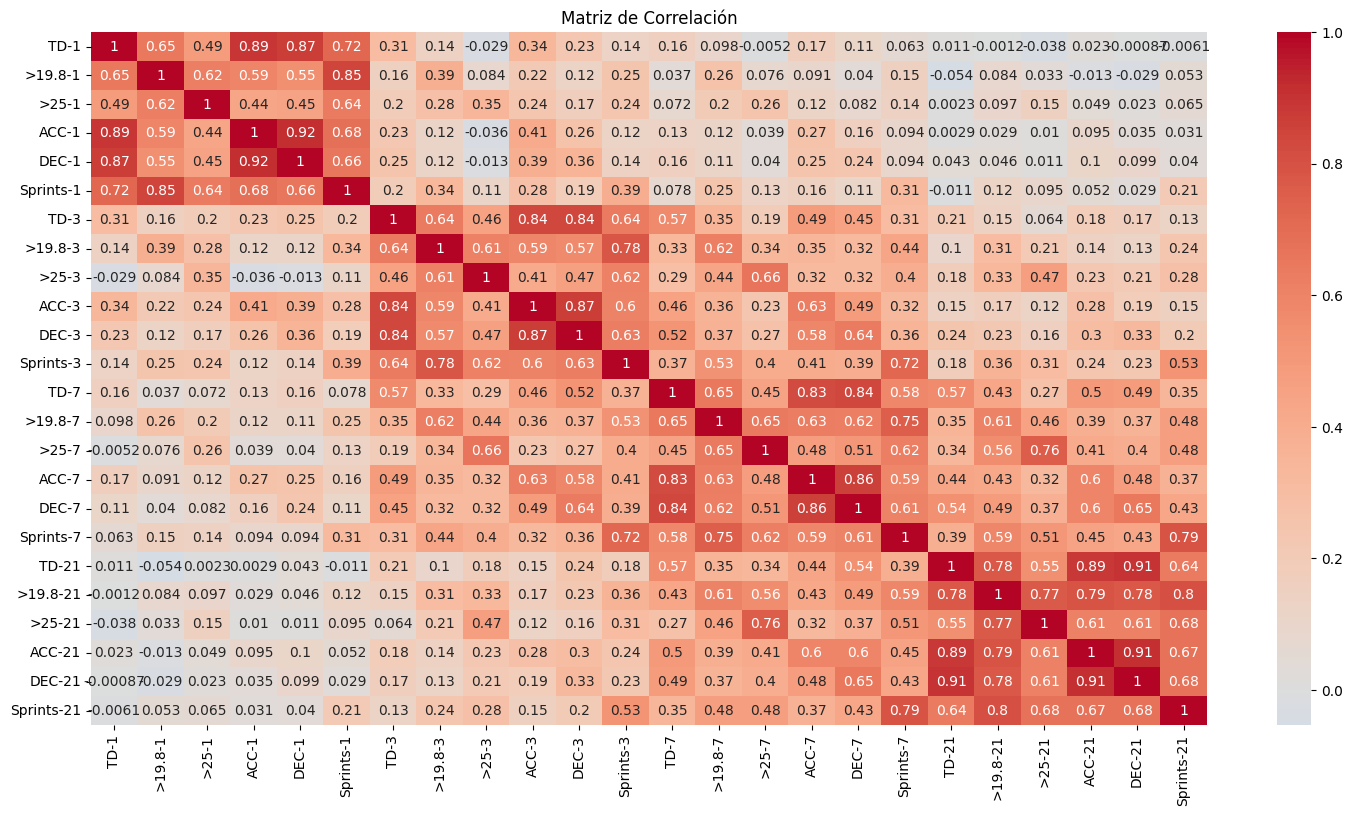

In [4]:
metrics = ['TD-1', '>19.8-1', '>25-1', 'ACC-1', 'DEC-1',
       'Sprints-1', 'TD-3', '>19.8-3', '>25-3', 'ACC-3', 'DEC-3',
       'Sprints-3', 'TD-7', '>19.8-7', '>25-7', 'ACC-7', 'DEC-7',
       'Sprints-7', 'TD-21', '>19.8-21', '>25-21', 'ACC-21',
       'DEC-21', 'Sprints-21']

# Calcular la matriz de correlación
correlation_matrix = df[metrics].corr()

# Mostrar la matriz de correlación
plt.figure(figsize=(18, 9))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Matriz de Correlación")
plt.show()


In [134]:
df_with_constant = add_constant(df[metrics])

# Calcular el VIF para cada columna
vif_data = pd.DataFrame()
vif_data["Variable"] = df_with_constant.columns
vif_data["VIF"] = [variance_inflation_factor(df_with_constant.values, i)
                   for i in range(df_with_constant.shape[1])]

# Mostrar el VIF
print(vif_data)

      Variable        VIF
0        const  13.939388
1         TD-1   9.561094
2      >19.8-1   5.443764
3        >25-1   2.371835
4        ACC-1  13.282435
5        DEC-1  11.543172
6    Sprints-1   7.459849
7         TD-3  13.467069
8      >19.8-3   8.094323
9        >25-3   4.360377
10       ACC-3  15.121114
11       DEC-3  15.943716
12   Sprints-3  13.605974
13        TD-7  17.056307
14     >19.8-7  10.080486
15       >25-7   6.764550
16       ACC-7  20.170154
17       DEC-7  21.582907
18   Sprints-7  22.113711
19       TD-21  18.043957
20    >19.8-21  10.795460
21      >25-21   5.854916
22      ACC-21  19.845209
23      DEC-21  21.194680
24  Sprints-21  14.647902


# Filter data by date or season


In [4]:
# Season 2022-2023
# df_filtered = df[df['season']=='2022-2023']

# Season 2021-2022
# df_filtered = df[df['season']=='2021-2022']

# Filter by no season
df_filtered = df.copy()

df_filtered = df_filtered[df_filtered['preseason-season'] != 'PRESEASON']

df_filtered.reset_index(drop=True, inplace=True)

df_sorted = df_filtered.sort_values(by='DATE', ascending=False).reset_index(drop=True)

df_sorted.head()

,DATE,Microcycle,Injury,season,preseason-season,TD,>19.8,>25,ACC,DEC,...,>25_MSWR,ACC_ACWR,ACC_MSWR,DEC_ACWR,DEC_MSWR,Position_CENTREBACK,Position_CENTREMIDFIELDER,Position_FULLBACK,Position_STRIKER,Position_WINGER
0,2023-05-10,M+2,0,2022-2023,SEASON,1763.0,25.0,0,16.0,6.0,...,0.000000,0.787879,0.550211,0.830769,0.580544,0,1,0,0,0
1,2023-05-10,M+2,0,2022-2023,SEASON,3115.0,173.0,0,33.0,51.0,...,0.000000,2.858824,0.668873,2.426471,0.588742,0,1,0,0,0
2,2023-05-09,M+1,0,2022-2023,SEASON,4444.0,98.0,0,51.0,36.0,...,0.377964,0.587629,0.579455,0.594470,0.470018,0,0,0,1,0
3,2023-05-08,MD,0,2022-2023,SEASON,9767.0,598.0,279,71.0,82.0,...,0.576959,1.053952,1.194518,1.001765,1.366355,0,0,0,0,1
4,2023-05-08,MD,0,2022-2023,SEASON,7107.0,407.0,149,47.0,58.0,...,0.766640,0.765306,1.115064,0.656977,1.070317,1,0,0,0,0


If filtered by season, add the Injuries from the other season.


In [15]:
# inj_2021 = df[(df['Injury'] == 1) & (df['season'] == '2021-2022')]
# df_filtered = pd.concat([df_filtered, inj_2021])

# ML Models

## Separate data into X, y and player_ids

Initialize the features we want to train

In [5]:
# metrics_train = ['Injury','TD-1', '>19.8-1', '>25-1', 'ACC-1', 'DEC-1', 'Sprints-1',
#        'Mins-1', 'TD_Rel-1', '>19.8_Rel-1', '>25_Rel-1', 'ACC_Rel-1',
#        'DEC_Rel-1', '% Max Speed-1', 'TD-3', '>19.8-3', '>25-3', 'ACC-3',
#        'DEC-3', 'Sprints-3', 'Mins-3', 'TD-7', '>19.8-7', '>25-7', 'ACC-7',
#        'DEC-7', 'Sprints-7', 'Mins-7', 'TD-21', '>19.8-21', '>25-21', 'ACC-21',
#        'DEC-21', 'Sprints-21', 'Mins-21', 'TD_ACWR', 'TD_MSWR', '>19.8_ACWR',
#        '>19.8_MSWR', '>25_ACWR', '>25_MSWR', 'ACC_ACWR', 'ACC_MSWR',
#        'DEC_ACWR', 'DEC_MSWR']

metrics_train = ['Injury','TD-1', '>19.8-1', '>25-1', 'ACC-1', 'DEC-1', 'Sprints-1',
       'Mins-1', 'TD_Rel-1', '>19.8_Rel-1', '>25_Rel-1', 'ACC_Rel-1',
       'DEC_Rel-1', '% Max Speed-1', 'TD-3', '>19.8-3', '>25-3', 'ACC-3',
       'DEC-3', 'Sprints-3', 'TD-7', '>19.8-7', '>25-7', 'ACC-7',
       'DEC-7', 'Sprints-7', 'TD-21', '>19.8-21', '>25-21', 'ACC-21',
       'DEC-21', 'Sprints-21', 'TD_ACWR', 'TD_MSWR', '>19.8_ACWR',
       '>19.8_MSWR', '>25_ACWR', '>25_MSWR', 'ACC_ACWR', 'ACC_MSWR',
       'DEC_ACWR', 'DEC_MSWR']

print(len(metrics_train))

42


## Split data

We want to also store the 'DATE' & 'PlayerID' columns for later comparison

In [6]:
extra_cols = df_sorted[['DATE', 'PlayerID']]
X = df_sorted[metrics_train]
y = df_sorted['Injury']

### Split by selecting 10 first injuries and its past 30 days

#### Days

In [273]:
# Parameter: Number of injuries for the test set
num_test_injuries = 14  # Number of injuries to include in the test set

# Step 1: Identify rows where `Injury` occurred (Injury == 1)
injury_rows = df_sorted[df_sorted['Injury'] == 1]

# Step 2: Select the first `num_test_injuries` injuries for the test set
test_injury_indices = injury_rows.index[:num_test_injuries]

# Step 3: Collect past 30 days of data for each test injury
test_indices = set()

days_before_test = 30
days_before_train = 80

for idx in test_injury_indices:
    injury_date = df_sorted.loc[idx, 'DATE']
    player_id = df_sorted.loc[idx, 'PlayerID']
    # Collect all rows for this player in the past 30 days
    past_30_days_indices = df_sorted[
        (df_sorted['PlayerID'] == player_id) &
        (df_sorted['DATE'] <= injury_date) &
        (df_sorted['DATE'] > injury_date - pd.Timedelta(days=days_before_test))
    ].index
    test_indices.update(past_30_days_indices)

# Step 4: Select the remaining injuries for the training set
remaining_injury_indices = injury_rows.index.difference(test_injury_indices)

train_indices = set()

for idx in remaining_injury_indices:
    injury_date = df_sorted.loc[idx, 'DATE']
    player_id = df_sorted.loc[idx, 'PlayerID']
    # Collect all rows for this player in the past 30 days, excluding test indices
    past_30_days_indices = df_sorted[
        (df_sorted['PlayerID'] == player_id) &
        (df_sorted['DATE'] <= injury_date) &
        (df_sorted['DATE'] > injury_date - pd.Timedelta(days=days_before_train))
    ].index
    train_indices.update(set(past_30_days_indices).difference(test_indices))

# Convert to lists
test_indices = list(test_indices)
train_indices = list(train_indices)

# Step 5: Create training and test sets
X_test = X.loc[test_indices]
y_test = y.loc[test_indices]

X_train = X.loc[train_indices]
y_train = y.loc[train_indices]

# Optional: Extra columns for test and training sets
extra_cols_test = extra_cols.loc[test_indices]
extra_cols_train = extra_cols.loc[train_indices]

# Sanity check for dataset sizes
print(f"Number of rows in test set: {len(X_test)}")
print(f"Number of rows in training set: {len(X_train)}")


Number of rows in test set: 269
Number of rows in training set: 693


#### Rows

In [7]:
# Ensure the data is sorted by PlayerID and DATE
df_sorted = df_sorted.sort_values(by=['PlayerID', 'DATE']).reset_index(drop=True)

# Parameter: Number of injuries for the test set
num_test_injuries = 7  # Number of injuries to include in the test set

# Identify rows where `Injury` occurred (Injury == 1)
injury_rows = df_sorted[df_sorted['Injury'] == 1]

# Step 1: Select indices for testing and training injuries
test_injury_indices = injury_rows.index[:num_test_injuries]
train_injury_indices = injury_rows.index[num_test_injuries:]

# Step 2: Collect rows for testing set
test_indices = list(test_injury_indices)  # Start with rows where Injury == 1
rows_before_test = 10

for idx in test_injury_indices:
    player_id = df_sorted.loc[idx, 'PlayerID']
    player_data = df_sorted[df_sorted['PlayerID'] == player_id]
    
    # Find the position of the current injury in the player's data
    injury_pos = player_data.index.get_loc(idx)
    
    # Collect the previous 30 rows (or as many as available)
    past_rows = player_data.iloc[max(0, injury_pos - rows_before_test):injury_pos].index.tolist()
    test_indices.extend(past_rows)

# Step 3: Collect rows for training set
train_indices = list(train_injury_indices)  # Start with rows where Injury == 1
rows_before_train = 20

for idx in train_injury_indices:
    player_id = df_sorted.loc[idx, 'PlayerID']
    player_data = df_sorted[df_sorted['PlayerID'] == player_id]
    
    # Find the position of the current injury in the player's data
    injury_pos = player_data.index.get_loc(idx)
    
    # Collect the previous 80 rows (or as many as available)
    past_rows = player_data.iloc[max(0, injury_pos - rows_before_train):injury_pos].index.tolist()
    train_indices.extend(past_rows)

# Step 4: Remove duplicates from indices
test_indices = list(set(test_indices))
train_indices = list(set(train_indices).difference(test_indices))

# Step 5: Create the datasets
training = df_sorted.loc[train_indices]
testing = df_sorted.loc[test_indices]

X_train = training[metrics_train].reset_index(drop=True)
X_test = testing[metrics_train].reset_index(drop=True)
y_train = training['Injury'].reset_index(drop=True)
y_test = testing['Injury'].reset_index(drop=True)

# Step 6: Sanity check for dataset sizes
print(f"Number of rows in test set: {len(testing)}")
print(f"Number of rows in training set: {len(training)}")
print(f"Number of injuries in test set: {testing['Injury'].sum()}")
print(f"Number of injuries in training set: {training['Injury'].sum()}")

Number of rows in test set: 77
Number of rows in training set: 561
Number of injuries in test set: 7
Number of injuries in training set: 28


In [8]:
print("No Lesión: " + str(X_train[X_train["Injury"] == 0].shape[0]))
print("Lesión: " + str(X_train[X_train["Injury"] == 1].shape[0]))
print(f"Porcentaje de lesionados en el dataset: {((X_train[X_train['Injury'] == 1].shape[0] / X_train.shape[0]) * 100):.2f}%")
print("No Lesión: " + str(X_test[X_test["Injury"] == 0].shape[0]))
print("Lesión: " + str(X_test[X_test["Injury"] == 1].shape[0]))
print(f"Porcentaje de lesionados en el dataset: {((X_test[X_test['Injury'] == 1].shape[0] / X_test.shape[0]) * 100):.2f}%")
X_train.drop(columns=['Injury'], inplace=True)
X_test.drop(columns=['Injury'], inplace=True)

No Lesión: 533
Lesión: 28
Porcentaje de lesionados en el dataset: 4.99%
No Lesión: 70
Lesión: 7
Porcentaje de lesionados en el dataset: 9.09%


### Split by first %X for validating and rest for training

In [162]:
extra_cols = df_sorted[['DATE', 'PlayerID']]
X = df_sorted[metrics_train]
y = df_sorted['Injury']

# Determine the split index for X% testing
percentage_validation = 0.3
split_index = int(percentage_validation * len(df_sorted))

# Split the data
X_test = X.iloc[:split_index].reset_index(drop=True)
X_train = X.iloc[split_index:].reset_index(drop=True)
y_test = y.iloc[:split_index].reset_index(drop=True)
y_train = y.iloc[split_index:].reset_index(drop=True)
extra_cols_test = extra_cols.iloc[:split_index].reset_index(drop=True)
extra_cols_train = extra_cols.iloc[split_index:].reset_index(drop=True)

Select less amount of data

In [163]:
print("No Lesión: " + str(X_train[X_train["Injury"] == 0].shape[0]))
print("Lesión: " + str(X_train[X_train["Injury"] == 1].shape[0]))
print(f"Porcentaje de lesionados en el dataset: {((X_train[X_train['Injury'] == 1].shape[0] / X_train.shape[0]) * 100):.2f}%")

No Lesión: 2883
Lesión: 22
Porcentaje de lesionados en el dataset: 0.76%


In [118]:
# Sort X_train by index
X_train = X_train.sort_index()  # Sort by date or relevant index if not already sorted.
y_train = y_train.sort_index()  # Ensure y_train matches X_train in order.

# Filter rows where 'Injury' == 1
injury_rows = X_train[X_train['Injury'] == 1]

# Get 30 days before each injury
# Assuming a datetime index, otherwise adjust for your date representation
indices_to_include = set(injury_rows.index)

for idx in injury_rows.index:
    # Include 30 rows before the 'Injury == 1', ensure not out of bounds
    start_idx = max(0, idx - 30)
    indices_to_include.update(range(start_idx, idx + 1))

# Create a dataframe with required rows (Injury == 1 and 30 days before)
selected_rows = X_train.loc[list(indices_to_include)]
selected_y = y_train.loc[selected_rows.index]  # Match y_train with selected rows

# Get the remaining rows not in `selected_rows`
remaining_rows = X_train.drop(selected_rows.index)
remaining_y = y_train.drop(selected_y.index)

# Proportion for sampling (e.g., 50%)
sample_proportion = 0.5
n_to_sample = int(len(X_train) * sample_proportion - len(selected_rows))

# Randomly sample from the remaining rows
sampled_rows = remaining_rows.sample(n=n_to_sample, random_state=42)
sampled_y = remaining_y.loc[sampled_rows.index]

# Combine the selected rows and sampled rows
X_train = pd.concat([selected_rows, sampled_rows]).sort_index().reset_index(drop=True)
y_train = pd.concat([selected_y, sampled_y]).sort_index().reset_index(drop=True)


In [119]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 809 entries, 0 to 808
Data columns (total 25 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Injury      809 non-null    int64  
 1   TD-1        809 non-null    float64
 2   >19.8-1     809 non-null    int64  
 3   >25-1       809 non-null    int64  
 4   ACC-1       809 non-null    float64
 5   DEC-1       809 non-null    float64
 6   Sprints-1   809 non-null    int64  
 7   TD-3        809 non-null    float64
 8   >19.8-3     809 non-null    float64
 9   >25-3       809 non-null    int64  
 10  ACC-3       809 non-null    float64
 11  DEC-3       809 non-null    float64
 12  Sprints-3   809 non-null    int64  
 13  TD-7        809 non-null    float64
 14  >19.8-7     809 non-null    float64
 15  >25-7       809 non-null    int64  
 16  ACC-7       809 non-null    float64
 17  DEC-7       809 non-null    float64
 18  Sprints-7   809 non-null    int64  
 19  TD-21       809 non-null    f

In [120]:
print("No Lesión: " + str(X_train[X_train["Injury"] == 0].shape[0]))
print("Lesión: " + str(X_train[X_train["Injury"] == 1].shape[0]))
print(f"Porcentaje de lesionados en el dataset: {((X_train[X_train['Injury'] == 1].shape[0] / X_train.shape[0]) * 100):.2f}%")

No Lesión: 789
Lesión: 20
Porcentaje de lesionados en el dataset: 2.47%


In [164]:
X_train.drop(columns=['Injury'], inplace=True)
X_test.drop(columns=['Injury'], inplace=True)

### Split random 

In [254]:
extra_cols = df_sorted[['DATE', 'PlayerID']]
X = df_sorted[metrics_train]
y = df_sorted['Injury']

# Split the data into training and test sets
# X_train, X_test, y_train, y_test, extra_cols_train, extra_cols_test = train_test_split(X, y, extra_cols, test_size=0.3, random_state=42, stratify=y)
X_train, X_test, y_train, y_test, extra_cols_train, extra_cols_test = train_test_split(X, y, extra_cols, test_size=0.2, random_state=42, stratify=y)

X_train.drop(columns=['Injury'], inplace=True)
X_test.drop(columns=['Injury'], inplace=True)

X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)
extra_cols_train.reset_index(drop=True, inplace=True)
extra_cols_test.reset_index(drop=True, inplace=True)


## SMOTE or SMOTEEN oversampling technique

In [9]:
# Apply SMOTE to training data
smote = SMOTE(random_state=42)
X_train , y_train = smote.fit_resample(X_train, y_train)

# Apply SMOTEEN to training data
# smote_enn = SMOTEENN(random_state=42)
# X_train, y_train = smote_enn.fit_resample(X_train, y_train)

print("Class distribution after SMOTE:")
print(pd.Series(y_train).value_counts())
print(pd.Series(y_train).value_counts())

Class distribution after SMOTE:
Injury
0    533
1    533
Name: count, dtype: int64
Injury
0    533
1    533
Name: count, dtype: int64


## Logistic Regression

Initialize logistic regression and normalize the data

In [22]:
# Create the model
logistic_model = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')

# Initialize the scaler
scaler = StandardScaler()

# Scale only metrics_numeric columns
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Logistic Regression Active learning 

to dynamically select data

In [19]:
# Initialize datasets
X_all = X_train_scaled  # Scaled features
y_all = y_train.values  # Labels

# Start with a small labeled dataset from the bottom of the sorted DataFrame
initial_samples = 50  # Number of initial samples
X_train_active = X_all[-initial_samples:]  # Select the last `initial_samples` rows
y_train_active = y_all[-initial_samples:]  # Corresponding labels

# Remaining unlabeled pool (everything except the selected rows)
X_pool = X_all[:-initial_samples]
y_pool = y_all[:-initial_samples]

print(f"Initial training set size: {len(X_train_active)}")
print(f"Remaining pool size: {len(X_pool)}")

Initial training set size: 50
Remaining pool size: 3148


Iteration 1/250:
Training Recall for Label 1: 0.0000
Training Size: 55
Iteration 2/250:
Training Recall for Label 1: 0.0000
Training Size: 60
Iteration 3/250:
Training Recall for Label 1: 0.0000
Training Size: 65
Iteration 4/250:
Training Recall for Label 1: 0.0000
Training Size: 70
Iteration 5/250:
Training Recall for Label 1: 0.0000
Training Size: 75
Iteration 6/250:
Training Recall for Label 1: 0.0000
Training Size: 80
Iteration 7/250:
Training Recall for Label 1: 0.0000
Training Size: 85
Iteration 8/250:
Training Recall for Label 1: 0.0000
Training Size: 90
Iteration 9/250:
Training Recall for Label 1: 0.0000
Training Size: 95
Iteration 10/250:
Training Recall for Label 1: 0.0000
Training Size: 100
Iteration 11/250:
Training Recall for Label 1: 0.0000
Training Size: 105
Iteration 12/250:
Training Recall for Label 1: 0.0000
Training Size: 110
Iteration 13/250:
Training Recall for Label 1: 0.0000
Training Size: 115
Iteration 14/250:
Training Recall for Label 1: 0.0000
Training Size: 

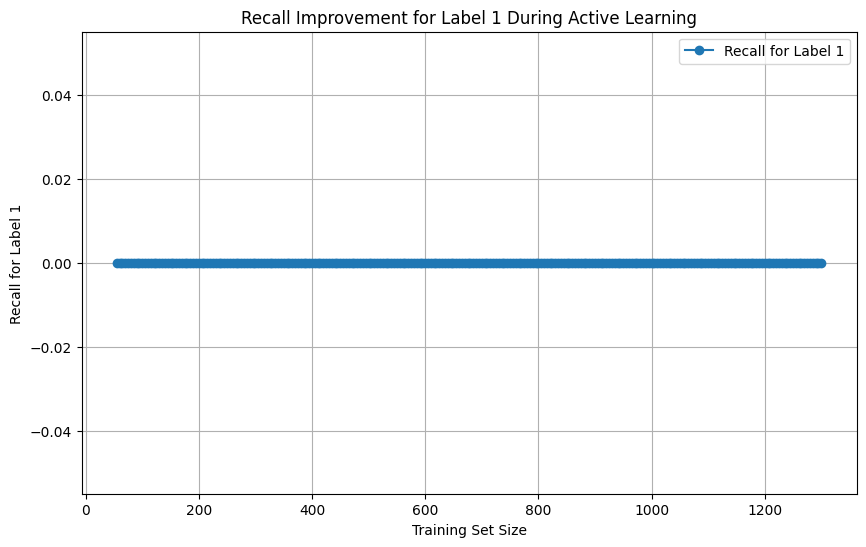

In [31]:
# Parameters for active learning
n_iterations = 250  # Number of active learning iterations
samples_per_iteration = 5  # Samples to add in each iteration

# To store metrics for visualization
train_recall_label1_scores = []
train_sizes = []

for i in range(n_iterations):
    # Train the model on the current labeled dataset
    logistic_model.fit(X_train_active, y_train_active)
    
    # Predict probabilities for the unlabeled pool
    probs = logistic_model.predict_proba(X_pool)[:, 1]
    
    # Find the most uncertain samples (probabilities closest to 0.5)
    uncertainty = np.abs(probs - 0.5)  # Uncertainty measure
    uncertain_indices = np.argsort(uncertainty)[:samples_per_iteration]
    
    # Add the most uncertain samples to the training set
    X_train_active = np.vstack((X_train_active, X_pool[uncertain_indices]))
    y_train_active = np.hstack((y_train_active, y_pool[uncertain_indices]))
    
    # Remove these samples from the pool
    X_pool = np.delete(X_pool, uncertain_indices, axis=0)
    y_pool = np.delete(y_pool, uncertain_indices, axis=0)
    
    # Evaluate recall for label 1
    y_train_pred = logistic_model.predict(X_train_active)
    recall_label1 = recall_score(y_train_active, y_train_pred, pos_label=1)  # Focus on label 1
    train_recall_label1_scores.append(recall_label1)
    train_sizes.append(len(y_train_active))
    
    print(f"Iteration {i + 1}/{n_iterations}:")
    print(f"Training Recall for Label 1: {recall_label1:.4f}")
    print(f"Training Size: {len(y_train_active)}")
    
    
# Plot recall improvement for label 1
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_recall_label1_scores, marker='o', label="Recall for Label 1")
plt.xlabel("Training Set Size")
plt.ylabel("Recall for Label 1")
plt.title("Recall Improvement for Label 1 During Active Learning")
plt.legend()
plt.grid()
plt.show()

In [65]:
# Evaluate on test data
y_test_pred = logistic_model.predict(X_test_scaled)
print("\nTest Set Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("Classification Report:\n", classification_report(y_test, y_test_pred))



Test Set Evaluation:
Accuracy: 0.8371757925072046
Confusion Matrix:
 [[579 108]
 [  5   2]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.84      0.91       687
           1       0.02      0.29      0.03         7

    accuracy                           0.84       694
   macro avg       0.50      0.56      0.47       694
weighted avg       0.98      0.84      0.90       694



### Regular logistic regression

In [24]:
# Train the model
logistic_model.fit(X_train_scaled, y_train)

# Predictions
y_train_pred = logistic_model.predict(X_train_scaled)
y_test_pred = logistic_model.predict(X_test_scaled)

# Probabilities
y_test_probs = logistic_model.predict_proba(X_test_scaled)[:, 1]  # Probabilities for the positive class

# Training evaluation
print("Training Set Evaluation:")
print("Accuracy:", accuracy_score(y_train, y_train_pred))
print("Confusion Matrix:\n", confusion_matrix(y_train, y_train_pred))
print("Classification Report:\n", classification_report(y_train, y_train_pred))

# Test evaluation
print("\nTest Set Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("Classification Report:\n", classification_report(y_test, y_test_pred))

Training Set Evaluation:
Accuracy: 0.7950089126559715
Confusion Matrix:
 [[421 112]
 [  3  25]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.79      0.88       533
           1       0.18      0.89      0.30        28

    accuracy                           0.80       561
   macro avg       0.59      0.84      0.59       561
weighted avg       0.95      0.80      0.85       561


Test Set Evaluation:
Accuracy: 0.8051948051948052
Confusion Matrix:
 [[60 10]
 [ 5  2]]
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.86      0.89        70
           1       0.17      0.29      0.21         7

    accuracy                           0.81        77
   macro avg       0.54      0.57      0.55        77
weighted avg       0.85      0.81      0.83        77



Find the best threshold

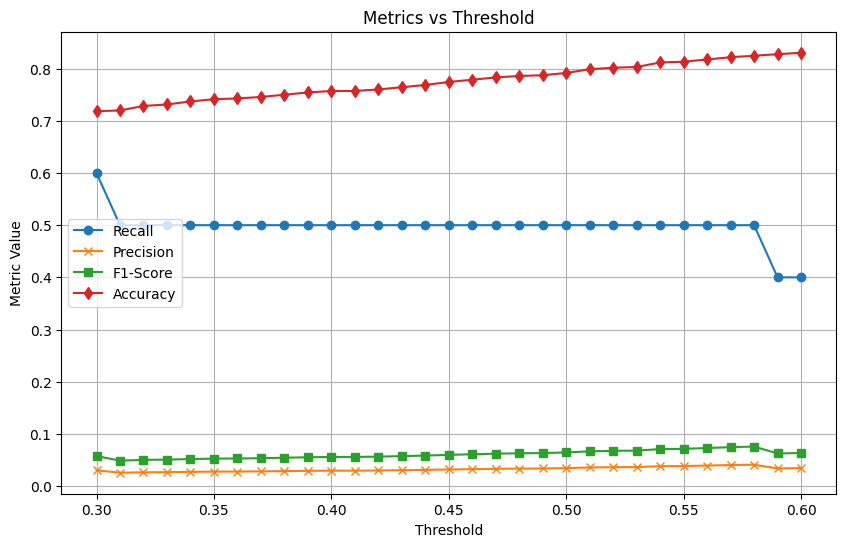

In [15]:
# Thresholds to evaluate (from 0.3 to 0.6 in steps of 0.01)
thresholds = np.arange(0.3, 0.61, 0.01)  # Thresholds from 0 to 1 in steps of 0.01

# Store results
results = []

for threshold in thresholds:
    # Generate predictions for the current threshold
    y_pred = (y_test_probs >= threshold).astype(int)
    
    # Calculate metrics
    recall = recall_score(y_test, y_pred, pos_label=1)  # Recall for label 1
    precision = precision_score(y_test, y_pred, pos_label=1)
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    
    # Append metrics and threshold to results
    results.append({
        'Threshold': threshold,
        'Recall': recall,
        'Precision': precision,
        'F1-Score': f1,
        'Accuracy': accuracy
    })
    
results_df = pd.DataFrame(results)

plt.figure(figsize=(10, 6))
plt.plot(results_df['Threshold'], results_df['Recall'], label='Recall', marker='o')
plt.plot(results_df['Threshold'], results_df['Precision'], label='Precision', marker='x')
plt.plot(results_df['Threshold'], results_df['F1-Score'], label='F1-Score', marker='s')
plt.plot(results_df['Threshold'], results_df['Accuracy'], label='Accuracy', marker='d')
plt.xlabel("Threshold")
plt.ylabel("Metric Value")
plt.title("Metrics vs Threshold")
plt.legend()
plt.grid()
plt.show()

ROC Curve with manually selecting the threshold

Number of unique thresholds: 23

Manually Selected Threshold: 0.44

Evaluation with Manually Selected Threshold:
Accuracy: 0.7686781609195402
Confusion Matrix:
 [[530 156]
 [  5   5]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.77      0.87       686
           1       0.03      0.50      0.06        10

    accuracy                           0.77       696
   macro avg       0.51      0.64      0.46       696
weighted avg       0.98      0.77      0.86       696



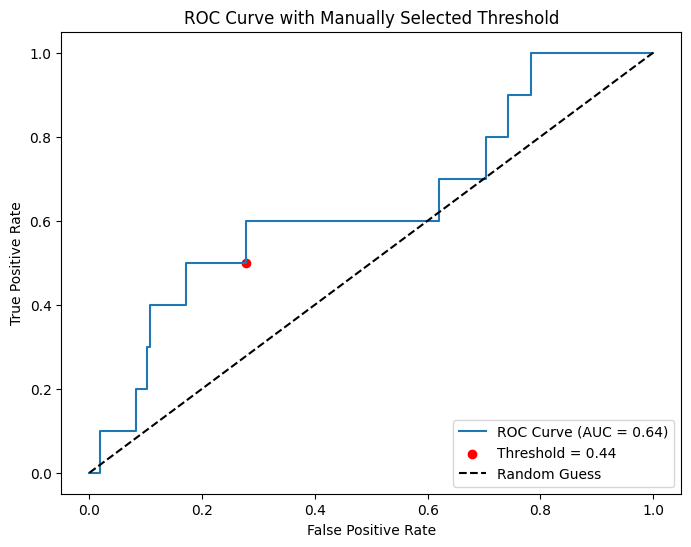

In [16]:
# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_test_probs)
roc_auc = auc(fpr, tpr)

# Print the number of unique thresholds
print(f"Number of unique thresholds: {len(thresholds)}")

# Manually select the threshold
manual_threshold = 0.44 # Manually chosen threshold
print(f"\nManually Selected Threshold: {manual_threshold:.2f}")

# Apply the manually selected threshold
y_test_pred_manual = (y_test_probs >= manual_threshold).astype(int)

# Evaluate the model with the manually selected threshold
print("\nEvaluation with Manually Selected Threshold:")
print("Accuracy:", accuracy_score(y_test, y_test_pred_manual))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred_manual))
print("Classification Report:\n", classification_report(y_test, y_test_pred_manual))

# Find the index of the manually selected threshold in the ROC data
# Using `thresholds` from the ROC calculation
manual_idx = np.argmin(np.abs(thresholds - manual_threshold))

# Plot the ROC curve and mark the manually selected threshold
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.scatter(fpr[manual_idx], tpr[manual_idx], color="red", label=f"Threshold = {manual_threshold:.2f}")
plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve with Manually Selected Threshold")
plt.legend(loc="lower right")
plt.show()

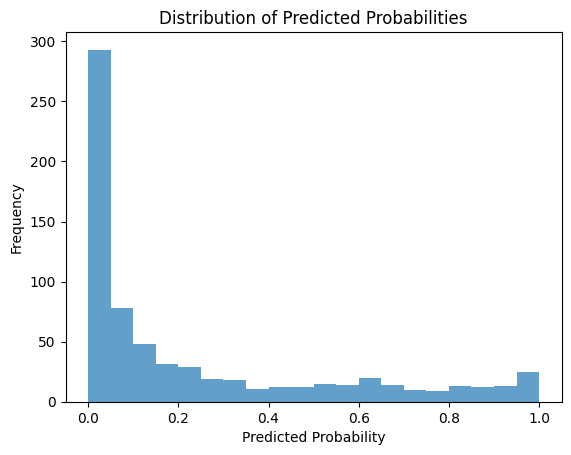

In [17]:
plt.hist(y_test_probs, bins=20, alpha=0.7)
plt.title("Distribution of Predicted Probabilities")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.show()

Store the coeficients

In [18]:
# Reset index for consistency
extra_cols_test.reset_index(inplace=True, drop=True)

# Get coefficients and intercept
coefficients = logistic_model.coef_[0]  # Coefficients
intercept = logistic_model.intercept_[0]  # Intercept
features = X_test.columns  # Feature names

# Create the player-score DataFrame
df_a = pd.DataFrame({
    'Player': extra_cols_test['PlayerID'],
    'Date': extra_cols_test['DATE'],
    'Score': y_test_probs,
    'Actual': y_test.reset_index(drop=True)
})

# Add feature values and calculate z (linear combination)
for i, feature in enumerate(features):
    df_a[feature] = X_test_scaled[:, i]  # Add scaled feature values
    df_a[f'Coeff_{feature}'] = coefficients[i]  # Add coefficient for each feature

# Calculate the linear combination (z) for each row
df_a['Linear_Combination'] = (
    np.dot(X_test_scaled, coefficients) + intercept
)

# Display the resulting DataFrame
print("\nPlayer, Date, Feature Contributions, Linear Combination, and Score DataFrame:")
df_a.head()



Player, Date, Feature Contributions, Linear Combination, and Score DataFrame:


,Player,Date,Score,Actual,TD-1,Coeff_TD-1,>19.8-1,Coeff_>19.8-1,>25-1,Coeff_>25-1,...,Coeff_>25_MSWR,ACC_ACWR,Coeff_ACC_ACWR,ACC_MSWR,Coeff_ACC_MSWR,DEC_ACWR,Coeff_DEC_ACWR,DEC_MSWR,Coeff_DEC_MSWR,Linear_Combination
0,10103,2023-03-23,0.164488,0,1.263325,-3.064588,-0.344699,-0.223905,-0.346502,-0.32636,...,0.62836,-1.086691,-2.355721,-0.368766,0.569522,-0.879983,0.574551,-0.872976,2.513648,-1.625209
1,37990,2023-03-29,0.977832,0,0.333646,-3.064588,0.700702,-0.223905,0.137442,-0.32636,...,0.62836,2.353997,-2.355721,0.448218,0.569522,2.268568,0.574551,0.992224,2.513648,3.786680
2,10103,2023-01-01,0.771654,0,-1.560936,-3.064588,-0.705183,-0.223905,-0.346502,-0.32636,...,0.62836,-0.024658,-2.355721,-0.127135,0.569522,-0.093156,0.574551,-0.246197,2.513648,1.217677
3,48692,2022-07-26,0.064123,0,-1.560936,-3.064588,-0.705183,-0.223905,-0.346502,-0.32636,...,0.62836,-0.602916,-2.355721,0.281165,0.569522,-0.735010,0.574551,0.383926,2.513648,-2.680673
4,10103,2022-07-31,0.955237,0,0.571551,-3.064588,0.508444,-0.223905,-0.170522,-0.32636,...,0.62836,0.106656,-2.355721,-0.101096,0.569522,0.295325,0.574551,0.044033,2.513648,3.060567


Find the features that affect the injuries the most

In [19]:
# Assuming your features are in a DataFrame
feature_importance = pd.DataFrame({
    "Feature": X_train.columns,  # Replace with your feature names
    "Importance": logistic_model.coef_[0]  # Coefficients from logistic regression
})

# Sort by importance
feature_importance = feature_importance.sort_values(by="Importance", ascending=False)

# Display the feature importance
print(feature_importance)

          Feature  Importance
13           TD-3    3.167892
43       DEC_MSWR    2.513648
25      Sprints-7    2.374382
12  % Max Speed-1    1.943623
31         DEC-21    1.894964
16          ACC-3    1.639008
4           DEC-1    1.609125
7        TD_Rel-1    1.371710
34        TD_ACWR    1.358638
28       >19.8-21    1.292225
24          DEC-7    1.285581
6          Mins-1    1.120032
29         >25-21    0.891212
38       >25_ACWR    0.795763
23          ACC-7    0.662255
39       >25_MSWR    0.628360
42       DEC_ACWR    0.574551
41       ACC_MSWR    0.569522
15          >25-3    0.298003
8     >19.8_Rel-1   -0.016502
1         >19.8-1   -0.223905
5       Sprints-1   -0.293598
36     >19.8_ACWR   -0.297010
2           >25-1   -0.326360
21        >19.8-7   -0.348604
10      ACC_Rel-1   -0.368542
18      Sprints-3   -0.409314
11      DEC_Rel-1   -0.650275
26         Mins-7   -0.769630
30         ACC-21   -0.827747
27          TD-21   -0.844529
33        Mins-21   -0.886371
20        

Select X quantity of the top features and retrain the model

In [22]:
# Extract top features by absolute importance
num_top_features =  20 # Adjust this to include the number of features you want
top_features = feature_importance.iloc[:num_top_features]["Feature"].values

print(f"Selected Top {num_top_features} Features: {top_features}")

Selected Top 20 Features: ['TD-3' 'DEC_MSWR' 'Sprints-7' '% Max Speed-1' 'DEC-21' 'ACC-3' 'DEC-1'
 'TD_Rel-1' 'TD_ACWR' '>19.8-21' 'DEC-7' 'Mins-1' '>25-21' '>25_ACWR'
 'ACC-7' '>25_MSWR' 'DEC_ACWR' 'ACC_MSWR' '>25-3' '>19.8_Rel-1']


Updated Model Evaluation:
Accuracy: 0.6709770114942529
Confusion Matrix:
 [[462 224]
 [  5   5]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.67      0.80       686
           1       0.02      0.50      0.04        10

    accuracy                           0.67       696
   macro avg       0.51      0.59      0.42       696
weighted avg       0.98      0.67      0.79       696



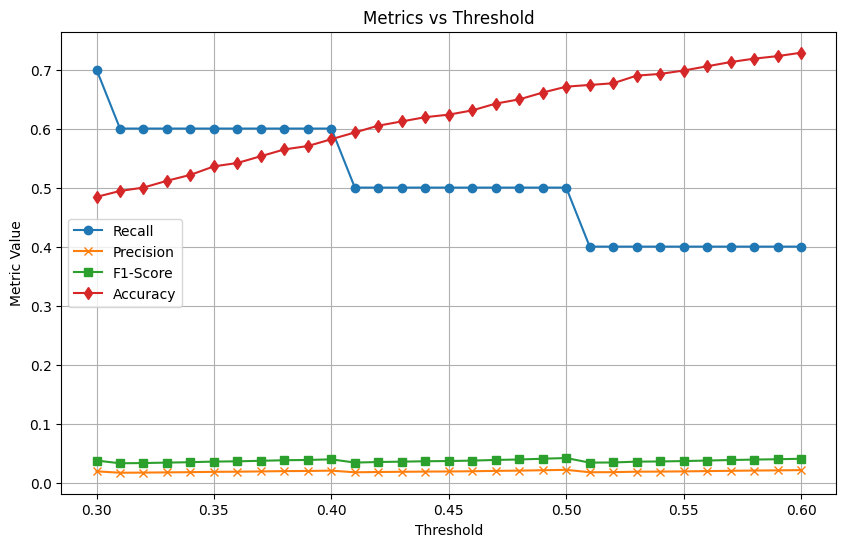

In [23]:
# Filter the training and testing data for top features
X_train_top = X_train_scaled[:, [X_train.columns.get_loc(f) for f in top_features]]
X_test_top = X_test_scaled[:, [X_train.columns.get_loc(f) for f in top_features]]

# Train logistic regression with top features
logistic_model_top = LogisticRegression(random_state=42, max_iter=1000)
logistic_model_top.fit(X_train_top, y_train)

# Predictions
y_test_pred_top = logistic_model_top.predict(X_test_top)
y_test_probs_top = logistic_model_top.predict_proba(X_test_top)[:, 1]

# Evaluate performance
print("Updated Model Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_test_pred_top))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred_top))
print("Classification Report:\n", classification_report(y_test, y_test_pred_top))

# Thresholds to evaluate (from 0.3 to 0.6 in steps of 0.01)
thresholds = np.arange(0.3, 0.61, 0.01)  # Thresholds from 0 to 1 in steps of 0.01

# Store results
results = []

for threshold in thresholds:
    # Generate predictions for the current threshold
    y_pred = (y_test_probs_top >= threshold).astype(int)
    
    # Calculate metrics
    recall = recall_score(y_test, y_pred, pos_label=1)  # Recall for label 1
    precision = precision_score(y_test, y_pred, pos_label=1)
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    
    # Append metrics and threshold to results
    results.append({
        'Threshold': threshold,
        'Recall': recall,
        'Precision': precision,
        'F1-Score': f1,
        'Accuracy': accuracy
    })
    
results_df = pd.DataFrame(results)

plt.figure(figsize=(10, 6))
plt.plot(results_df['Threshold'], results_df['Recall'], label='Recall', marker='o')
plt.plot(results_df['Threshold'], results_df['Precision'], label='Precision', marker='x')
plt.plot(results_df['Threshold'], results_df['F1-Score'], label='F1-Score', marker='s')
plt.plot(results_df['Threshold'], results_df['Accuracy'], label='Accuracy', marker='d')
plt.xlabel("Threshold")
plt.ylabel("Metric Value")
plt.title("Metrics vs Threshold")
plt.legend()
plt.grid()
plt.show()

Number of unique thresholds: 23

Manually Selected Threshold: 0.55

Evaluation with Manually Selected Threshold:
Accuracy: 0.6982758620689655
Confusion Matrix:
 [[482 204]
 [  6   4]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.70      0.82       686
           1       0.02      0.40      0.04        10

    accuracy                           0.70       696
   macro avg       0.50      0.55      0.43       696
weighted avg       0.97      0.70      0.81       696



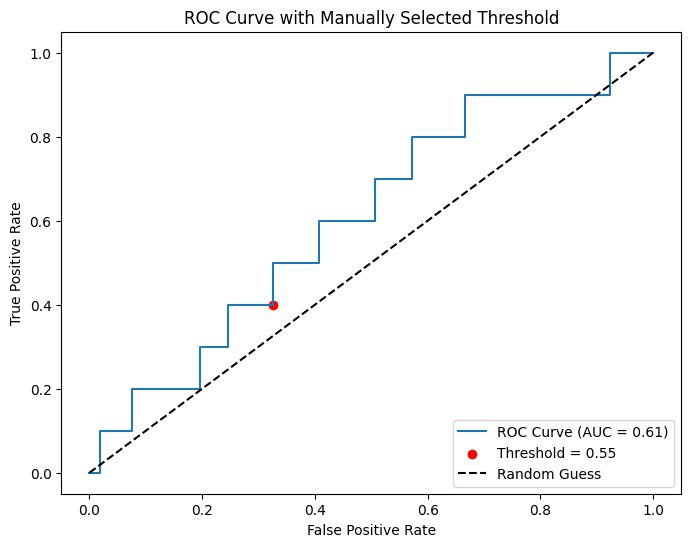

In [24]:
# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_test_probs_top)
roc_auc = auc(fpr, tpr)

# Print the number of unique thresholds
print(f"Number of unique thresholds: {len(thresholds)}")

# Manually select the threshold
manual_threshold = 0.55  # Manually chosen threshold
print(f"\nManually Selected Threshold: {manual_threshold:.2f}")

# Apply the manually selected threshold
y_test_pred_manual = (y_test_probs_top >= manual_threshold).astype(int)

# Evaluate the model with the manually selected threshold
print("\nEvaluation with Manually Selected Threshold:")
print("Accuracy:", accuracy_score(y_test, y_test_pred_manual))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred_manual))
print("Classification Report:\n", classification_report(y_test, y_test_pred_manual))

# Find the index of the manually selected threshold in the ROC data
# Using `thresholds` from the ROC calculation
manual_idx = np.argmin(np.abs(thresholds - manual_threshold))

# Plot the ROC curve and mark the manually selected threshold
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.scatter(fpr[manual_idx], tpr[manual_idx], color="red", label=f"Threshold = {manual_threshold:.2f}")
plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve with Manually Selected Threshold")
plt.legend(loc="lower right")
plt.show()

## RNN

In [105]:
import pandas as pd
import numpy as np

def create_rnn_datasets(df_sorted, RNN_metrics, sequence_length=30, train_ratio=0.7, val_ratio=0.15):
    """
    Create training, validation, and testing datasets for RNNs.
    
    Args:
        df_sorted (pd.DataFrame): The sorted DataFrame containing the data.
        RNN_metrics (list): List of metric columns to be used as features for training.
        sequence_length (int): The length of each sequence (e.g., 30 days).
        train_ratio (float): The ratio of data to use for training.
        val_ratio (float): The ratio of data to use for validation.
        
    Returns:
        tuple: (X_train, y_train), (X_val, y_val), (X_test, y_test)
        - Each dataset is in the shape (num_sequences, sequence_length, num_features).
    """
    sequences = []
    labels = []
    
    # Group by PlayerID to create sequences for each player
    grouped = df_sorted.groupby('PlayerID')
    
    for player_id, group in grouped:
        # Ensure the group is sorted by date (if not already)
        group = group.sort_values(by='DATE')
        
        # Iterate through the rows to create sequences
        for i in range(len(group) - sequence_length):
            # Get the current sequence (last 30 days)
            sequence = group.iloc[i:i+sequence_length][RNN_metrics].values
            # Get the injury label at the end of the sequence
            label = group.iloc[i+sequence_length]['Injury']
            
            # Append the sequence and label
            sequences.append(sequence)
            labels.append(label)
    
    # Convert to numpy arrays
    sequences = np.array(sequences)  # Shape: (num_sequences, sequence_length, num_features)
    labels = np.array(labels)        # Shape: (num_sequences,)
    
    # Split into train, validation, and test datasets
    num_sequences = len(sequences)
    train_end = int(num_sequences * train_ratio)
    val_end = train_end + int(num_sequences * val_ratio)
    
    X_train, y_train = sequences[:train_end], labels[:train_end]
    X_val, y_val = sequences[train_end:val_end], labels[train_end:val_end]
    X_test, y_test = sequences[val_end:], labels[val_end:]
    
    return (X_train, y_train), (X_val, y_val), (X_test, y_test)


In [106]:
# RNN_metrics =  ['TD-3' 'DEC_MSWR' 'Sprints-7' '% Max Speed-1' 'DEC-21' 'ACC-3' 'DEC-1'
#  'TD_Rel-1' 'TD_ACWR' '>19.8-21' 'DEC-7' 'Mins-1' '>25-21' '>25_ACWR'
#  'ACC-7' '>25_MSWR' 'DEC_ACWR' 'ACC_MSWR' '>25-3' '>19.8_Rel-1']
RNN_metrics = metrics_train

In [107]:
RNN_metrics = metrics_train
(X_train, y_train), (X_val, y_val), (X_test, y_test) = create_rnn_datasets(df_sorted, RNN_metrics)

print("Training Data Shape:", X_train.shape, y_train.shape)
print("Validation Data Shape:", X_val.shape, y_val.shape)
print("Testing Data Shape:", X_test.shape, y_test.shape)

Training Data Shape: (2421, 30, 45) (2421,)
Validation Data Shape: (518, 30, 45) (518,)
Testing Data Shape: (520, 30, 45) (520,)


In [108]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# Assuming X_train, X_val, X_test are 3D: (n_sequences, sequence_length, n_features)
# Flatten the data for scaling
n_sequences, sequence_length, n_features = X_train.shape

# Reshape data to 2D for scaling
X_train_flat = X_train.reshape(-1, n_features)  # Shape: (n_sequences * sequence_length, n_features)
X_val_flat = X_val.reshape(-1, n_features)      # Shape: (n_sequences * sequence_length, n_features)
X_test_flat = X_test.reshape(-1, n_features)    # Shape: (n_sequences * sequence_length, n_features)

# Initialize and fit the scaler on training data only
scaler = StandardScaler()
X_train_scaled_flat = scaler.fit_transform(X_train_flat)
X_val_scaled_flat = scaler.transform(X_val_flat)
X_test_scaled_flat = scaler.transform(X_test_flat)

# Reshape the scaled data back to 3D for RNN input
X_train_scaled = X_train_scaled_flat.reshape(n_sequences, sequence_length, n_features)
X_val_scaled = X_val_scaled_flat.reshape(X_val.shape[0], sequence_length, n_features)
X_test_scaled = X_test_scaled_flat.reshape(X_test.shape[0], sequence_length, n_features)

# Outputs
print(f"Train Shape: {X_train_scaled.shape}, Validation Shape: {X_val_scaled.shape}, Test Shape: {X_test_scaled.shape}")
print(f"y_train Distribution: {np.bincount(y_train)}, y_val Distribution: {np.bincount(y_val)}, y_test Distribution: {np.bincount(y_test)}")


Train Shape: (2421, 30, 45), Validation Shape: (518, 30, 45), Test Shape: (520, 30, 45)
y_train Distribution: [2401   20], y_val Distribution: [514   4], y_test Distribution: [516   4]


In [109]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

def create_rnn(input_shape):
    model = Sequential()

    # LSTM layer
    model.add(LSTM(units=64, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(0.3))

    # Second LSTM layer
    model.add(LSTM(units=32, return_sequences=False))
    model.add(Dropout(0.3))

    # Fully connected output layer
    model.add(Dense(units=1, activation='sigmoid'))  # Binary classification

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Input shape for RNN
input_shape = (timesteps, n_features)

# Create the model
model = create_rnn(input_shape)

/Users/tommylas/Documents/FootballAnalytics/WatfordFC/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [110]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Early stopping and learning rate scheduler
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)


# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

# Convert to a dictionary for Keras
class_weights = {i: weight for i, weight in enumerate(class_weights)}

# Train the model
history = model.fit(
    X_train_scaled, 
    y_train, 
    epochs=50, 
    batch_size=32, 
    validation_data=(X_val, y_val), 
    verbose=1, 
    callbacks=[early_stopping, lr_scheduler],
    class_weight = class_weights
)


Epoch 1/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8723 - loss: 0.8114 - val_accuracy: 0.2239 - val_loss: 0.7503 - learning_rate: 0.0010
Epoch 2/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6924 - loss: 0.7057 - val_accuracy: 0.2162 - val_loss: 0.7566 - learning_rate: 0.0010
Epoch 3/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6415 - loss: 0.6711 - val_accuracy: 0.7278 - val_loss: 0.6105 - learning_rate: 0.0010
Epoch 4/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7391 - loss: 0.6700 - val_accuracy: 0.4788 - val_loss: 0.6479 - learning_rate: 0.0010
Epoch 5/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6498 - loss: 0.4953 - val_accuracy: 0.8707 - val_loss: 0.5175 - learning_rate: 0.0010
Epoch 6/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6412 - loss: 0.4887 - val_accuracy: 0.9923 - val_loss: 0.4173 - learning_rate: 0.0010
Epoch 7/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8402 - loss: 0.3715 - val_accuracy: 

In [111]:
loss, accuracy = model.evaluate(X_train_scaled, y_test, verbose=0)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

# Get predictions
test_predictions = model.predict(X_train_scaled)
ipi_test_scores = test_predictions[:, 0]  # Injury Prevention Index

# Generate predictions for the test set
y_pred_probs = model.predict(X_train_scaled)  # Probabilities from the model
y_pred = (y_pred_probs > 0.5).astype(int)  # Convert probabilities to binary predictions

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
print("Confusion Matrix:")
print(cm)


ValueError: Data cardinality is ambiguous. Make sure all arrays contain the same number of samples.'x' sizes: 2421
'y' sizes: 520


## ANN

In [10]:
# metrics_ANN =  ['TD-3' 'DEC_MSWR' 'Sprints-7' '% Max Speed-1' 'DEC-21' 'ACC-3' 'DEC-1'
#  'TD_Rel-1' 'TD_ACWR' '>19.8-21' 'DEC-7' 'Mins-1' '>25-21' '>25_ACWR'
#  'ACC-7' '>25_MSWR' 'DEC_ACWR' 'ACC_MSWR' '>25-3' '>19.8_Rel-1']
metrics_ANN = metrics_train

In [11]:
# Initialize the scaler
scaler = StandardScaler()

# Assuming X_train_selected and X_test_selected are defined
X_train_selected = X_train
X_test_selected = X_test

# Scale the data
X_train_scaled = scaler.fit_transform(X_train_selected)
X_test_scaled = scaler.transform(X_test_selected)

# Apply PCA
pca = PCA(n_components=8)  # Retain 95% of variance
# X_train_pca = pca.fit_transform(X_train_scaled)
# X_test_pca = pca.transform(X_test_scaled)

X_train_pca = X_train_scaled
X_test_pca = X_test_scaled

# Define the ANN model with regularization
def create_ann(input_dim):
    model = Sequential()
    # Input layer and first hidden layer with L2 regularization
    model.add(Dense(units=32, activation='relu', input_dim=input_dim, kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.2))
    
    # Second hidden layer with L2 regularization
    model.add(Dense(units=32, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.2))
    
    # Output layer (for classification with probabilities)
    model.add(Dense(units=1, activation='sigmoid'))  # Using 'sigmoid' for binary classification

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Example usage:
input_dim = X_train_pca.shape[1]

# Create the model
model = create_ann(input_dim)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)


# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weights = {0: 1.0, 1: 10.0}

history = model.fit(
    X_train_pca, 
    y_train, 
    epochs=100, 
    batch_size=32, 
    validation_split=0.2, 
    verbose=1, 
    callbacks=[early_stopping, lr_scheduler],
    class_weight=class_weights
)

# Evaluate the model
loss, accuracy = model.evaluate(X_test_pca, y_test, verbose=0)
print(f"Loss: {loss}, Accuracy: {accuracy}")

# Get probabilities for the test set as percentages
probabilities = model.predict(X_test_pca)
probabilities_percentage = probabilities * 100

Epoch 1/100


/Users/tommylas/Documents/FootballAnalytics/WatfordFC/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5654 - loss: 4.1791 - val_accuracy: 0.9019 - val_loss: 1.1292 - learning_rate: 0.0010
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4253 - loss: 2.9589 - val_accuracy: 1.0000 - val_loss: 0.9326 - learning_rate: 0.0010
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3866 - loss: 2.6903 - val_accuracy: 1.0000 - val_loss: 0.8561 - learning_rate: 0.0010
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4367 - loss: 2.4215 - val_accuracy: 1.0000 - val_loss: 0.8053 - learning_rate: 0.0010
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4705 - loss: 2.2249 - val_accuracy: 1.0000 - val_loss: 0.7605 - learning_rate: 0.0010
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4902 - loss: 2.0801 - val_accuracy: 1.0000 - val_loss: 0.7321 - learning_rate: 0.0010
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5262 - loss: 2.0074 - val_accuracy: 1.000

In [12]:
# Get predictions (rounded to 0 or 1)
y_pred = (probabilities > 0.35).astype(int)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Classification report
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

Confusion Matrix:
[[64  6]
 [ 5  2]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.91      0.92        70
           1       0.25      0.29      0.27         7

    accuracy                           0.86        77
   macro avg       0.59      0.60      0.59        77
weighted avg       0.87      0.86      0.86        77



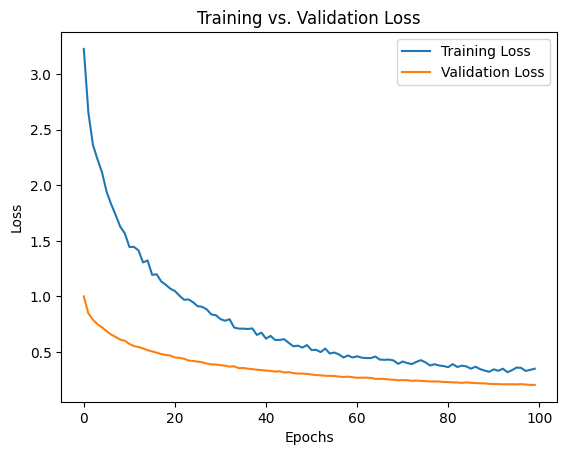

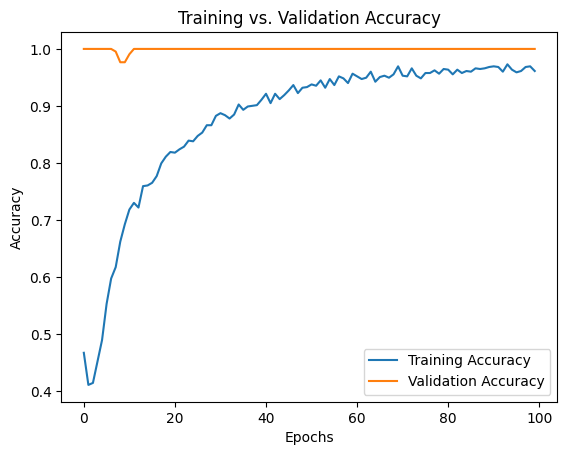

In [13]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.show()

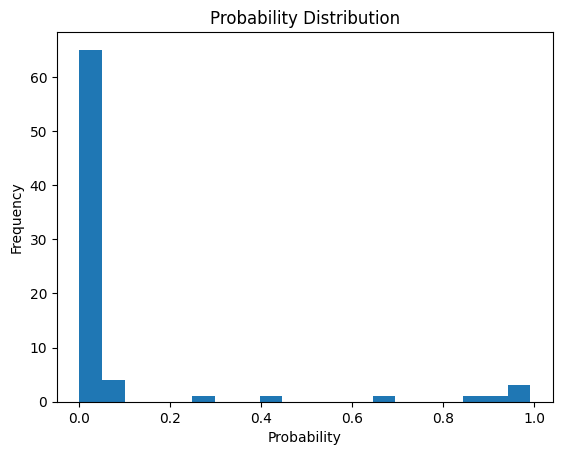

In [14]:
plt.hist(probabilities, bins=20)
plt.title("Probability Distribution")
plt.xlabel("Probability")
plt.ylabel("Frequency")
plt.show()

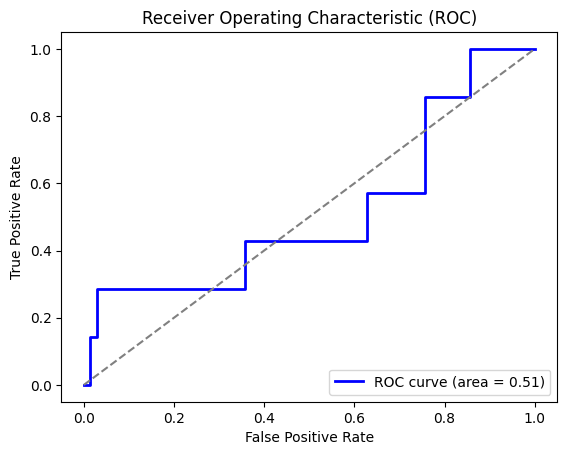

In [15]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calculate FPR, TPR, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, probabilities)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC)")
plt.legend(loc="lower right")
plt.show()


/Users/tommylas/Documents/FootballAnalytics/WatfordFC/.venv/lib/python3.12/site-packages/shap/explainers/_deep/deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")
/Users/tommylas/Documents/FootballAnalytics/WatfordFC/.venv/lib/python3.12/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(1066, 41))']
  warnings.warn(msg)
/Users/tommylas/Documents/FootballAnalytics/WatfordFC/.venv/lib/python3.12/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected

SHAP values shape: (41, 1)
X_test_pca shape: (77, 41)
Expanded SHAP values shape: (77, 41)


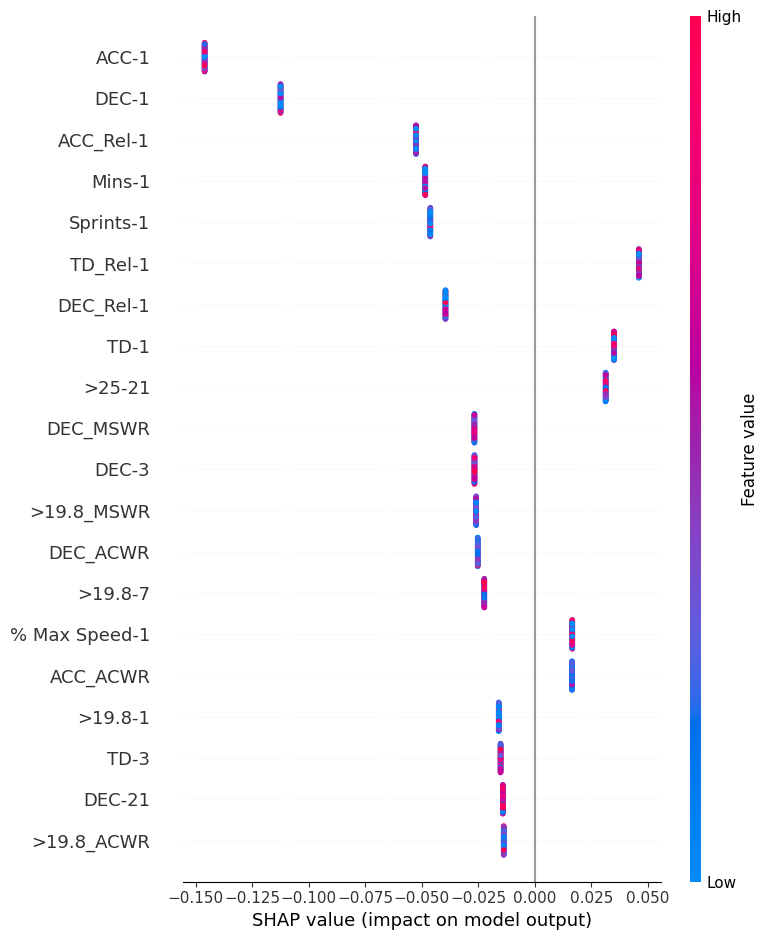

In [17]:
# Initialize SHAP explainer
explainer = shap.DeepExplainer(model, X_train_pca)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test_pca)
shap_values = shap_values[0]  # Extract contributions for the positive class

# Debugging shapes
print("SHAP values shape:", shap_values.shape)
print("X_test_pca shape:", X_test_pca.shape)

# Adjust SHAP values if necessary
if shap_values.shape == (41, 1):
    shap_values = shap_values.T  # Adjust to (1, 41)
    
if shap_values.shape == (1, 41):
    shap_values = np.tile(shap_values, (X_test_pca.shape[0], 1))  # Expand to (77, 41)
    print("Expanded SHAP values shape:", shap_values.shape)

# Visualize SHAP values
shap.summary_plot(shap_values, X_test_pca, feature_names=X_train_selected.columns)


## SVM

SVM & GridSearch

In [35]:
# Standardize the features
scaler = StandardScaler()
X_train_val_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize SMOTE
smote = SMOTE(random_state=42)
# Apply SMOTE to training data
X_resampled, y_resampled = smote.fit_resample(X_train_val_scaled, y_train)

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'gamma': [0.01, 0.1, 1, 'scale', 'auto'],
    'kernel': ['rbf', 'poly'],
    'class_weight': ['balanced', {0: 1, 1: 10}]
}

# Initialize the SVM model
svm_model = SVC(probability=True, random_state=42)

# Grid search for hyperparameter tuning
grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid, cv=5, scoring='roc_auc', verbose=3)
grid_search.fit(X_resampled, y_resampled)

# Output the best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best AUC Score:", grid_search.best_score_)

# Use the best estimator for testing
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)
y_prob = best_model.predict_proba(X_test_scaled)[:, 1]

# Classification report
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

# ROC-AUC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print("Test Set AUC:", roc_auc)

Fitting 5 folds for each of 80 candidates, totalling 400 fits
[CV 1/5] END C=0.01, class_weight=balanced, gamma=0.01, kernel=rbf;, score=0.880 total time=   0.1s
[CV 2/5] END C=0.01, class_weight=balanced, gamma=0.01, kernel=rbf;, score=0.859 total time=   0.1s
[CV 3/5] END C=0.01, class_weight=balanced, gamma=0.01, kernel=rbf;, score=0.801 total time=   0.1s
[CV 4/5] END C=0.01, class_weight=balanced, gamma=0.01, kernel=rbf;, score=0.918 total time=   0.1s
[CV 5/5] END C=0.01, class_weight=balanced, gamma=0.01, kernel=rbf;, score=0.881 total time=   0.1s
[CV 1/5] END C=0.01, class_weight=balanced, gamma=0.01, kernel=poly;, score=0.566 total time=   0.0s
[CV 2/5] END C=0.01, class_weight=balanced, gamma=0.01, kernel=poly;, score=0.674 total time=   0.0s
[CV 3/5] END C=0.01, class_weight=balanced, gamma=0.01, kernel=poly;, score=0.581 total time=   0.0s
[CV 4/5] END C=0.01, class_weight=balanced, gamma=0.01, kernel=poly;, score=0.728 total time=   0.0s
[CV 5/5] END C=0.01, class_weight=

SVM with manually selecting the parameters

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.70      0.80        70
           1       0.12      0.43      0.19         7

    accuracy                           0.68        77
   macro avg       0.52      0.56      0.50        77
weighted avg       0.85      0.68      0.74        77

Test Set AUC: 0.5571428571428572


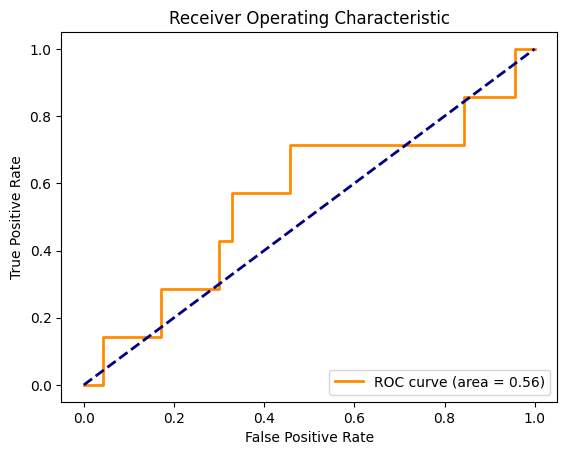

In [36]:
# Standardize the features
scaler = MinMaxScaler()
X_train_val_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize SMOTE
smote = SMOTE(random_state=42)
# Apply SMOTE to training data
X_resampled, y_resampled = smote.fit_resample(X_train_val_scaled, y_train)

# # SMOTE for oversampling the training data
# smote_enn = SMOTEENN(random_state=42)
# X_resampled, y_resampled = smote_enn.fit_resample(X_train_val_scaled, y_train_val)

# Train the SVM model
svm_model = SVC(kernel='rbf', class_weight="balanced", gamma='auto',probability=True, random_state=42)
svm_model.fit(X_resampled, y_resampled)

# Evaluate on the test set
y_pred = svm_model.predict(X_test_scaled)
y_prob = svm_model.predict_proba(X_test_scaled)[:, 1]

# Classification report
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

# ROC-AUC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print("Test Set AUC:", roc_auc)

# Plot ROC Curve (optional)
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


## XGBoost Model

### Perform Recursive Feature Elimination with Cross-Validation (RFECV) to find the best variables

In [43]:
# Base parameters for XGBClassifier
base_params = {
    'objective': 'binary:logistic',
    'colsample_bytree': 0.8,  # Feature subsampling
    'subsample': 0.8,         # Row subsampling
    'eval_metric': 'auc',
    'alpha': 0,              # L1 regularization
    'gamma': 0,              # Minimum loss reduction
    'max_depth': 5,
    'learning_rate': 0.07,
    'n_estimators': 500
}

# Initialize the XGBClassifier
rfe_model = XGBClassifier(**base_params)

# Perform RFE for feature selection
rfe = RFE(
    estimator=rfe_model,
    n_features_to_select=50,  # Select exactly X features
    step=1  # Remove one feature at a time
)

# Fit RFE to X_train
rfe.fit(X_train, y_train)

# Get selected feature names
selected_features = X_train.columns[rfe.support_]
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

print(f"Selected Features (RFE): {selected_features.tolist()}")
print(f"Number of features selected: {len(selected_features)}")

/Users/tommylas/Documents/FootballAnalytics/WatfordFC/.venv/lib/python3.12/site-packages/sklearn/feature_selection/_rfe.py:291: UserWarning: Found n_features_to_select=50 > n_features=41. There will be no feature selection and all features will be kept.
  warnings.warn(


Selected Features (RFE): ['TD-1', '>19.8-1', '>25-1', 'ACC-1', 'DEC-1', 'Sprints-1', 'Mins-1', 'TD_Rel-1', '>19.8_Rel-1', '>25_Rel-1', 'ACC_Rel-1', 'DEC_Rel-1', '% Max Speed-1', 'TD-3', '>19.8-3', '>25-3', 'ACC-3', 'DEC-3', 'Sprints-3', 'TD-7', '>19.8-7', '>25-7', 'ACC-7', 'DEC-7', 'Sprints-7', 'TD-21', '>19.8-21', '>25-21', 'ACC-21', 'DEC-21', 'Sprints-21', 'TD_ACWR', 'TD_MSWR', '>19.8_ACWR', '>19.8_MSWR', '>25_ACWR', '>25_MSWR', 'ACC_ACWR', 'ACC_MSWR', 'DEC_ACWR', 'DEC_MSWR']
Number of features selected: 41


### Grid Search XGBoost

In [44]:
# Updated base parameters with added regularization
base_params_xgboost = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'subsample': 0.8,        
    'colsample_bytree': 0.8 
}

# Expanded parameter grid
param_grid = {
    'learning_rate': [0.01,0.05,0.07],
    'max_depth': [5, 7, 9, 11],
    'n_estimators': [300,500,700],
    'scale_pos_weight': [10,12,15,17],
    'alpha': [0],
    'gamma': [0],
}

scaler = StandardScaler()
X_train_selected = scaler.fit_transform(X_train_selected)
X_test_selected = scaler.transform(X_test_selected)

model = XGBClassifier(**base_params_xgboost)

# Stratified K-Fold Cross-Validation
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='recall',  # Optimize for ROC-AUC
    cv=stratified_cv,
    verbose=1,
    n_jobs=-1
)

# Fit GridSearchCV on the training dataset
grid_search.fit(X_train_selected, y_train)

# Get the best model and parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_roc_auc = grid_search.best_score_

# Print best results
print(f"Best ROC-AUC (Grid Search): {best_roc_auc:.4f}")
print(f"Best Parameters: {best_params}")

Fitting 5 folds for each of 144 candidates, totalling 720 fits


/Users/tommylas/Documents/FootballAnalytics/WatfordFC/.venv/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best ROC-AUC (Grid Search): 0.9962
Best Parameters: {'alpha': 0, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 700, 'scale_pos_weight': 17}


### Train the model with the best parameters

Final Test ROC-AUC: 0.5469
Accuracy: 0.8571
Precision: 0.2500
Recall: 0.2857
F1 Score: 0.2667
Confusion Matrix:
[[64  6]
 [ 5  2]]


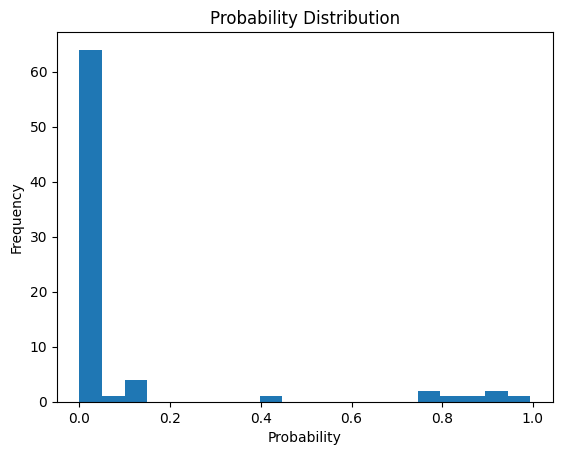

In [45]:
base_params_xgboost = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'subsample': 0.8,        
    'colsample_bytree': 0.8 
}

param_grid = {
   'learning_rate': 0.05,  # Explore smaller learning rates
   'max_depth': 5,             # Test broader depth values
   'n_estimators': 700,     # Include larger estimators
   'scale_pos_weight': 17,
   'alpha': 0,  # L regularization
   'gamma': 0,  # Minimum loss reduction
}

# Train the model with the best parameters from the grid search
# final_model = XGBClassifier(
#     **base_params_xgboost,
#     **param_grid,
# )


scaler = StandardScaler()
X_train_selected = scaler.fit_transform(X_train_selected)
X_test_selected = scaler.transform(X_test_selected)

# pca = PCA(n_components=30)  # Retain 95% of variance
# X_train_pca = pca.fit_transform(X_train_scaled)
# X_test_pca = pca.transform(X_test_scaled)

# Train the model with manually selected parameters
final_model = XGBClassifier(
    **base_params_xgboost,
    **param_grid,
)

# Train
final_model.fit(X_train_selected,
                y_train,
                verbose=True
)

# Predict class labels (0 or 1) on the test set
y_pred_probs = final_model.predict_proba(X_test_selected)[:, 1]
# Apply custom threshold
threshold = 0.4
y_pred = (y_pred_probs >= threshold).astype(int)
test_roc_auc = roc_auc_score(y_test, y_pred_probs)
print(f"Final Test ROC-AUC: {test_roc_auc:.4f}")

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Precision
precision = precision_score(y_test, y_pred)
print(f"Precision: {precision:.4f}")

# Recall
recall = recall_score(y_test, y_pred)
print(f"Recall: {recall:.4f}")

# F1 Score
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

plt.hist(y_pred_probs, bins=20)
plt.title("Probability Distribution")
plt.xlabel("Probability")
plt.ylabel("Frequency")
plt.show()


### Prepare the data to export in excel

In [40]:
X_test = X_test_selected.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
extra_cols_test = extra_cols_test.reset_index(drop=True)

AttributeError: 'numpy.ndarray' object has no attribute 'reset_index'

Categorize the percentages into levels of risk

In [58]:
def categorize_risk(percentage):
    if percentage < 40:
        return 'Low Risk'
    elif 40 <= percentage < 70:
        return 'Medium Risk'
    else:
        return 'High Risk'

Create a df to later convert to excel and export

In [56]:
# Evaluate the best model on the test set
y_probs = final_model.predict_proba(X_test_selected)[:, 1]
test_roc_auc = roc_auc_score(y_test, y_probs)

print(f"Test ROC-AUC: {test_roc_auc:.4f}")

# Convert the probabilities of injury risk (Class 1) to percentages
injury_risk_percentage = y_probs * 100

# Categorize the injury risk percentages
risk_levels = [categorize_risk(percentage) for percentage in injury_risk_percentage]

# Create the `results` DataFrame with only relevant metrics and calculated values
results = pd.DataFrame({
    'Player_ID': extra_cols_test['PlayerID'],
    'Date': extra_cols_test['DATE'], # Add player IDs
    'Actual_Label': y_test,  # Add actual labels
    '%': injury_risk_percentage,
    'Risk_Level': risk_levels
}).join(X_test[['TD-7', '>25-7', 'ACC-7', 'DEC-7', 'Sprints-7']])  # Add only relevant metrics

Test ROC-AUC: 0.7844


In [207]:
# Define risk level colors
color_mapping = {
    'High Risk': 'FF9999',  # Light Red
    'Medium Risk': 'FFFF99',  # Light Yellow
    'Low Risk': '99FF99'  # Light Green
}

# file_path_export = '/content/drive/MyDrive/WATFORD FC/Datos GPS/results.xlsx'
file_path_export = 'results.xlsx'

wb = Workbook()

# Write `results` to the first sheet
ws = wb.active
ws.title = "Injury Risk Results"
for r_idx, row in enumerate(dataframe_to_rows(results, index=True, header=True), start=1):
    for c_idx, value in enumerate(row, start=1):
        ws.cell(row=r_idx, column=c_idx, value=value)

# Conditional formatting for `results`
risk_level_col_idx = list(results.columns).index("Risk_Level") + 2
for row in ws.iter_rows(min_row=2, max_row=ws.max_row, min_col=risk_level_col_idx, max_col=risk_level_col_idx):
    for cell in row:
        risk_level = cell.value
        if risk_level in color_mapping:
            cell.fill = PatternFill(start_color=color_mapping[risk_level], end_color=color_mapping[risk_level], fill_type="solid")

# Save the workbook
wb.save(file_path_export)

## Mutual Info Regression formula (excluded for now)

In [ ]:
from sklearn.feature_selection import mutual_info_regression
import numpy as np

def mrmr_manual_regression(X, y, num_features):
    selected_features = []
    remaining_features = list(range(X.shape[1]))
    
    # Calculate mutual information for relevance (regression)
    relevance = mutual_info_regression(X, y)
    
    for _ in range(num_features):
        scores = []
        for feature in remaining_features:
            # Calculate redundancy with already selected features
            redundancy = np.mean([mutual_info_regression(X[:, feature].reshape(-1, 1), X[:, sel]) 
                                  for sel in selected_features]) if selected_features else 0
            
            # mRMR score = relevance - redundancy
            score = relevance[feature] - redundancy
            scores.append((feature, score))
        
        # Select the feature with the maximum score
        best_feature = max(scores, key=lambda x: x[1])[0]
        selected_features.append(best_feature)
        remaining_features.remove(best_feature)
    
    return selected_features

selected_features_indexes = mrmr_manual_regression(X.values, y.values, 8)

feature_names = X.columns  # Assuming X is a pandas DataFrame
selected_feature_names = [feature_names[i] for i in selected_features_indexes]

print("Selected Features:", selected_feature_names)

X = X[selected_feature_names]